# 01 — Exploratory Data Analysis (EDA)

This notebook explores the structure and characteristics of the Drug Usage Detection dataset.
We inspect missing values, class distribution, and text properties.

In [1]:
# --- Standard Library ---
import re
from collections import Counter

# --- Data Science & Scientific Computing ---
import numpy as np
import pandas as pd

# --- Visualization & Notebook Tools ---
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns

# --- Natural Language Processing (NLTK) ---
import nltk
from nltk.corpus import stopwords

# --- Utilities & Progress ---
import watermark
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm_nb

# --- Configuration, Magics, and Downloads ---
%load_ext watermark
%matplotlib inline

# NLTK Resource Downloads
nltk.download('stopwords')

# Global Seeds and Settings
RANDOM_SEED = 333
np.random.seed(RANDOM_SEED)
tqdm.pandas()
stop_words = set(stopwords.words('spanish'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lhbelfanti/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
%watermark -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.12.12
IPython version      : 9.10.0

Compiler    : Clang 17.0.0 (clang-1700.6.3.2)
OS          : Darwin
Release     : 25.2.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit

Git hash: de5f13f5ed5901d1f3238579912568961838c4df

tqdm      : 4.67.3
watermark : 2.5.0
re        : 2.2.1
matplotlib: 3.10.8
numpy     : 1.26.4
seaborn   : 0.13.2
IPython   : 9.10.0
nltk      : 3.9.2
pandas    : 3.0.0



In [3]:
plt.style.use('../style.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

---
## 1. Load Data

In [4]:
df = pd.read_csv('../data/raw/corpus.csv')
print(f"Dataset loaded: {df.shape[0]} rows × {df.shape[1]} columns")
df.head()

Dataset loaded: 3000 rows × 12 columns


,ID,TweetAuthor,TweetAvatar,TweetText,TweetImages,IsTweetAReply,QuoteAuthor,QuoteAvatar,QuoteText,QuoteImages,IsQuoteAReply,Categorization
0,6011,@arimakaveli,https://pbs.twimg.com/profile_images/161359113...,"""Que ganas de fumarme un porrito y tomarme una...",NaN,False,NaN,NaN,NaN,NaN,NaN,NEGATIVE
1,6012,@_gomezmartin,https://pbs.twimg.com/profile_images/160208182...,Escuchar lana del rey es como tomarme una líne...,NaN,False,NaN,NaN,NaN,NaN,NaN,NEGATIVE
2,6013,@georcavilla,https://pbs.twimg.com/profile_images/124016284...,"A las 10 am ya tomé un latte, un expreso y est...",NaN,False,NaN,NaN,NaN,NaN,NaN,NEGATIVE
3,6014,@Ampii17sosa,https://pbs.twimg.com/profile_images/179821310...,"Para mi que estaba pensando en ""que ganas de t...",NaN,False,@vilcapugio,https://pbs.twimg.com/profile_images/977668339...,"Todos miran la moneda menos Maradona, que mira...",https://pbs.twimg.com/media/ER9pESAWsAA_wlK?fo...,False,NEGATIVE
4,6015,@Aye_S_,https://pbs.twimg.com/profile_images/182846168...,Amo tomarme una línea de colectivos que no con...,NaN,False,NaN,NaN,NaN,NaN,NaN,NEGATIVE


## 2. Basic Inspection

In [5]:
print(df.info())
print("\nMissing values per column:")
display(df.isnull().sum())

<class 'pandas.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ID              3000 non-null   int64 
 1   TweetAuthor     3000 non-null   str   
 2   TweetAvatar     3000 non-null   str   
 3   TweetText       3000 non-null   str   
 4   TweetImages     910 non-null    str   
 5   IsTweetAReply   3000 non-null   bool  
 6   QuoteAuthor     44 non-null     str   
 7   QuoteAvatar     44 non-null     str   
 8   QuoteText       36 non-null     str   
 9   QuoteImages     16 non-null     str   
 10  IsQuoteAReply   44 non-null     object
 11  Categorization  3000 non-null   str   
dtypes: bool(1), int64(1), object(1), str(9)
memory usage: 902.0+ KB
None

Missing values per column:


ID                   0
TweetAuthor          0
TweetAvatar          0
TweetText            0
TweetImages       2090
IsTweetAReply        0
QuoteAuthor       2956
QuoteAvatar       2956
QuoteText         2964
QuoteImages       2984
IsQuoteAReply     2956
Categorization       0
dtype: int64

### Keep relevant columns
`TweetText` (the raw text) and `Categorization` (the label).

In [6]:
df_clean = df[['TweetText', 'Categorization']].copy()
df_clean.rename(columns={'TweetText': 'text', 'Categorization': 'label'}, inplace=True)
df_clean.head()

,text,label
0,"""Que ganas de fumarme un porrito y tomarme una...",NEGATIVE
1,Escuchar lana del rey es como tomarme una líne...,NEGATIVE
2,"A las 10 am ya tomé un latte, un expreso y est...",NEGATIVE
3,"Para mi que estaba pensando en ""que ganas de t...",NEGATIVE
4,Amo tomarme una línea de colectivos que no con...,NEGATIVE


## 3. Text Length Analysis

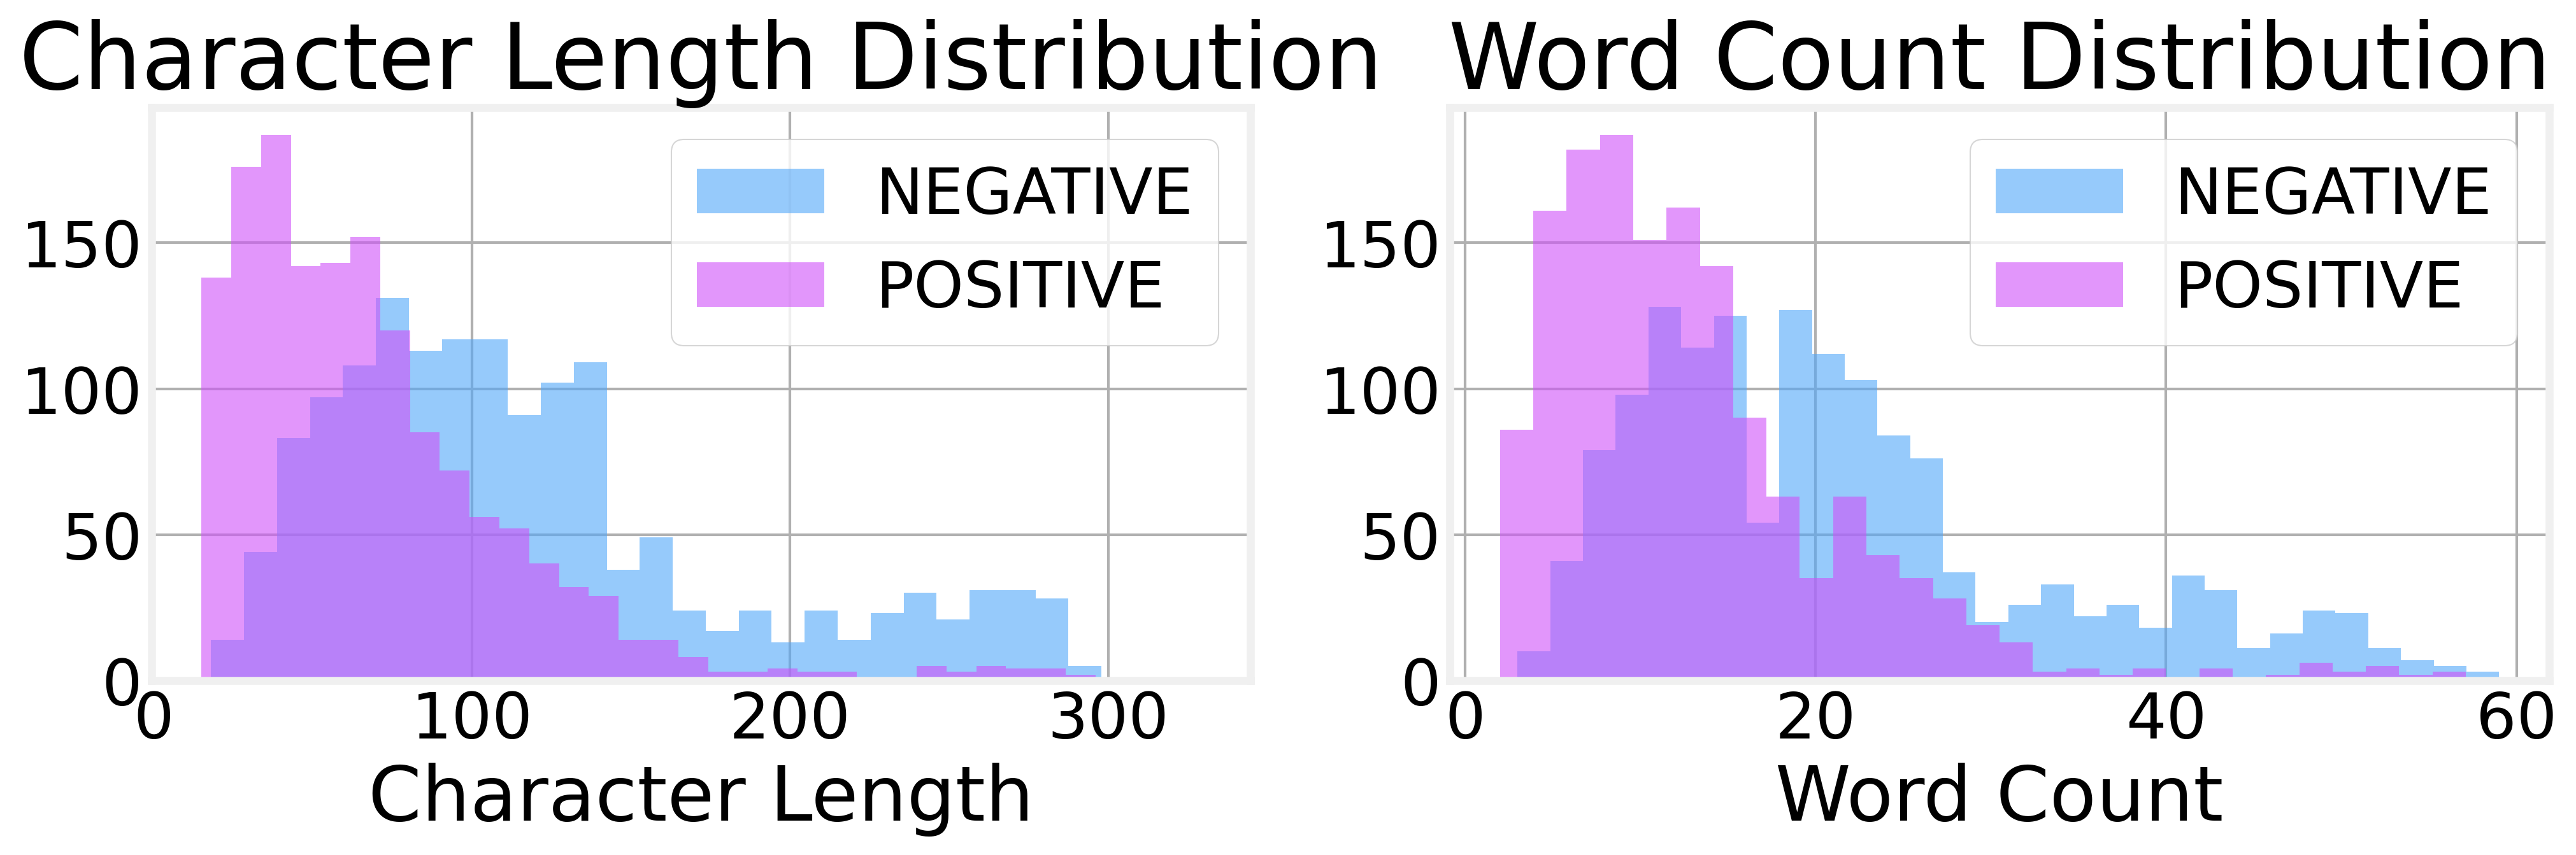

         char_length                                                           \
               count        mean        std   min    25%    50%    75%    max   
label                                                                           
NEGATIVE      1500.0  119.394667  65.114383  18.0  72.00  104.0  142.0  329.0   
POSITIVE      1500.0   68.868667  44.776199  15.0  36.75   59.0   87.0  296.0   

         word_count                                                     
              count       mean        std  min   25%   50%   75%   max  
label                                                                   
NEGATIVE     1500.0  21.714667  11.871726  3.0  13.0  19.0  27.0  59.0  
POSITIVE     1500.0  13.020667   8.681464  2.0   7.0  11.0  17.0  59.0  


In [11]:
df_clean['char_length'] = df_clean['text'].astype(str).apply(len)
df_clean['word_count'] = df_clean['text'].astype(str).apply(lambda x: len(x.split()))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for label, color in zip(df_clean['label'].unique(), colors[:2]):
    subset = df_clean[df_clean['label'] == label]
    axes[0].hist(subset['char_length'], bins=30, alpha=0.6, label=label, color=color)
    axes[1].hist(subset['word_count'], bins=30, alpha=0.6, label=label, color=color)

axes[0].set_title('Character Length Distribution')
axes[0].set_xlabel('Character Length')
axes[0].legend()

axes[1].set_title('Word Count Distribution')
axes[1].set_xlabel('Word Count')
axes[1].legend()

plt.tight_layout()
plt.show()

print(df_clean.groupby('label')[['char_length', 'word_count']].describe())

## 4. Most Common Words
Top words per class after removing Spanish stop words.

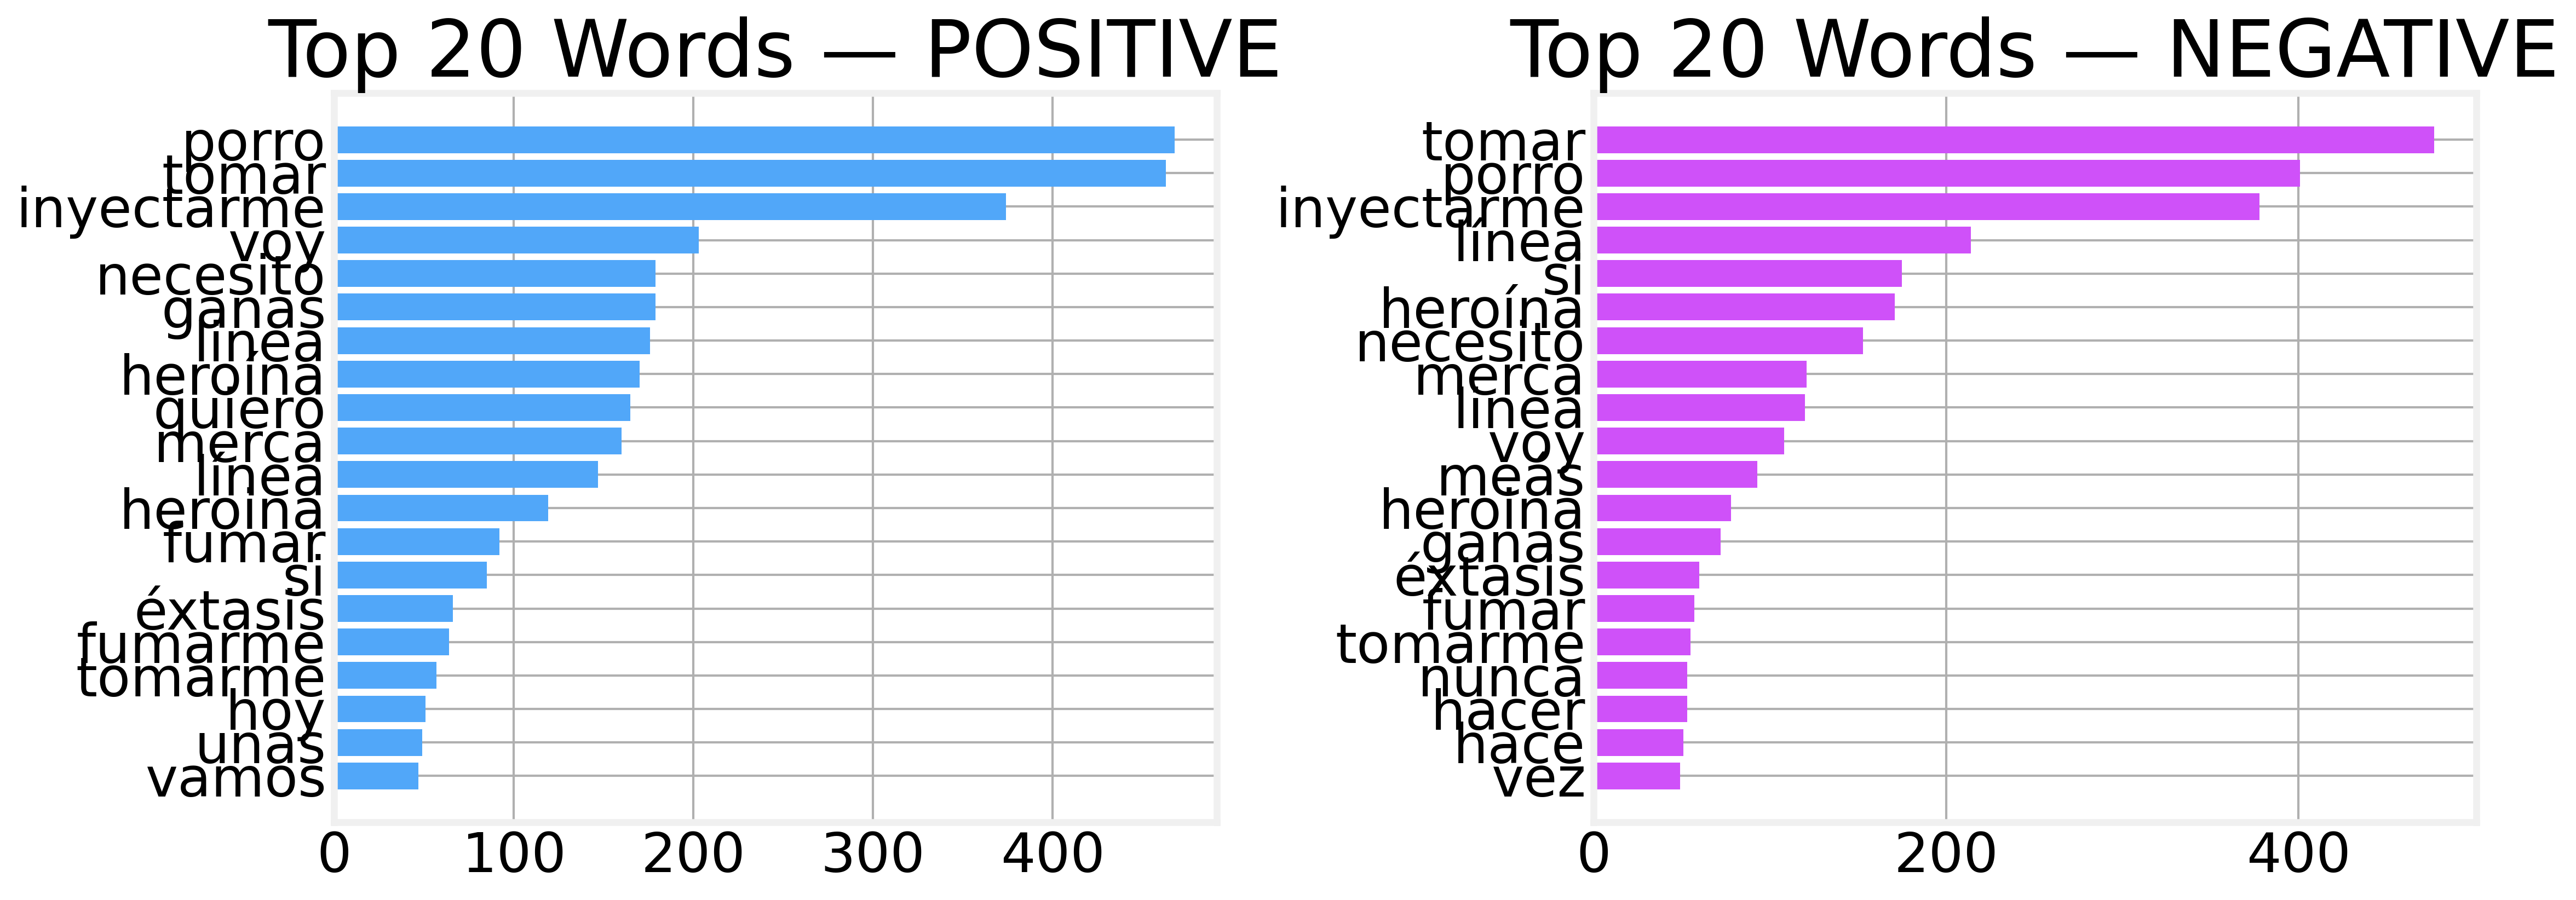

In [12]:
def get_top_words(texts, n=20):
    """Extract the n most common words from a series of texts, excluding stop words."""
    words = []
    for text in texts:
        tokens = str(text).lower().split()
        tokens = [t for t in tokens if t.isalpha() and t not in stop_words]
        words.extend(tokens)
    return Counter(words).most_common(n)

positive_words = get_top_words(df_clean[df_clean['label'] == 'POSITIVE']['text'])
negative_words = get_top_words(df_clean[df_clean['label'] == 'NEGATIVE']['text'])

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# POSITIVE class
words_p, counts_p = zip(*positive_words)
axes[0].barh(words_p[::-1], counts_p[::-1], color=colors[0])
axes[0].set_title('Top 20 Words — POSITIVE')

# NEGATIVE class
words_n, counts_n = zip(*negative_words)
axes[1].barh(words_n[::-1], counts_n[::-1], color=colors[1])
axes[1].set_title('Top 20 Words — NEGATIVE')

plt.tight_layout()
plt.show()

As we can see and as it was expected, the main words are drug-related terminology.

---
## Summary of the results

This notebook performed an exploratory data analysis on the drug usage classification dataset.

*   **Step 1: Load Data**: The dataset was successfully loaded, containing **3000** rows and **12** columns.
*   **Step 2: Basic Inspection**: We confirmed that the target variable `Categorization` is perfectly balanced (1500 POSITIVE, 1500 NEGATIVE) and critical columns have no missing values.
*   **Step 3: Text Length Analysis**: The distribution of tweet lengths was analyzed, showing the variability in text size across the corpus.
*   **Step 4: Most Common Words**: After removing Spanish stopwords, we identified the most frequent terms. This confirms the presence of domain-specific (drug-related) terminology both classes.
